In [1]:
from ppsim import Simulation, StatePlotter, time_trials
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
# Either this backend or the qt backend is necessary to use the StatePlotter Snapshot object for dynamic visualization while the simulation runs
%matplotlib widget
# Each code cell needs to be run successively. Clicking 'run all' will not let the plots be generated until all cells finish running.

# 3-state oscillator

The 3-state rock-paper-scissors protocol is a simple set of rules that gives oscillatory dynamics:

In [2]:
r, p, s = 'rock', 'paper', 'scissors'
rps = {
    (r,s): (r,r),
    (p,r): (p,p),
    (s,p): (s,s)
}

This rule has been studied in many different contexts, such as [evolutionary game theory](https://www.cambridge.org/core/books/evolutionary-games-and-population-dynamics/A8D94EBE6A16837E7CB3CED24E1948F8). 

This exact protocol has also been [implemented experimentally using DNA strand displacement](https://science.sciencemag.org/content/358/6369/eaal2052)

<img src="https://science.sciencemag.org/content/sci/358/6369/eaal2052/F1.large.jpg" width="400" />

Let's take a look and what the dynamics do, starting from a uniform initial distribution:

<Axes: xlabel='time (n interactions)'>

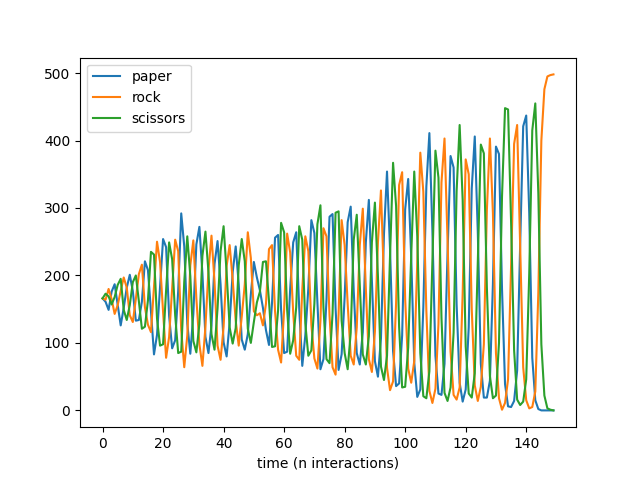

In [3]:
def uniform_config(n):
    return {r: n // 3, p: n // 3, s: n // 3}
n = 500
sim = Simulation(uniform_config(n), rps)
sim.run()
sim.history.plot()

We can see the amplitude of the fluctuations varies until one species dies out. [Several](https://arxiv.org/abs/1001.5235) [papers](https://arxiv.org/abs/q-bio/0605042) have analyzed these dynamics using stochastic differential equations to get analytic estimates for this time to extinction.

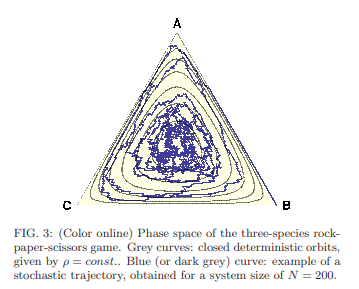

One considers the more general case of varied reaction rates:

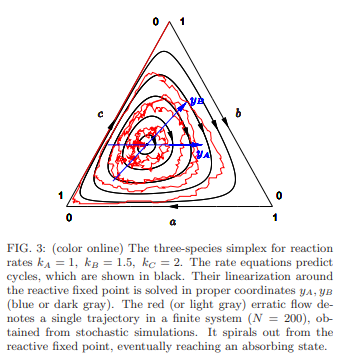

We can simulate that by adding varied probabilies associated to each interaction:

<Axes: xlabel='time (n interactions)'>

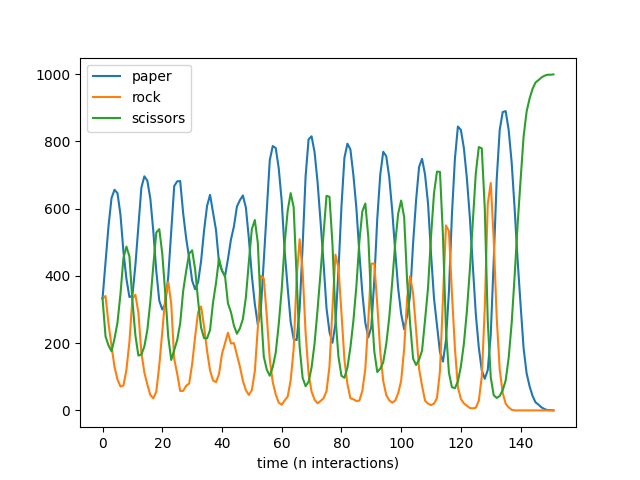

In [4]:
p_r, p_p, p_s = 0.9, 0.6, 0.3
imbalanced_rps = {
    (r,s): {(r,r): p_r},
    (p,r): {(p,p): p_p},
    (s,p): {(s,s): p_s}
}

n = 1000
sim = Simulation(uniform_config(n), imbalanced_rps)
sim.run()
sim.history.plot()

A [population protocols paper](https://hal.inria.fr/hal-01137486/document) gave some rigorous bounds on the behavior of this protocol.
They first showed that it belongs to a wider family of protocols that all become extinct in at most polynomial time:

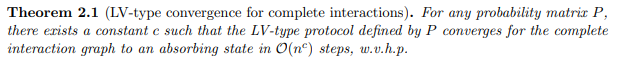

They also show that for most initial configurations, the state we converge to is equally likely to be any of the three states, making the consensus decision a 'fair die roll':

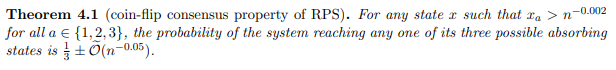

Taking a look a larger simulation, we can see that the time to extinction is scaling with the population size:

<Axes: xlabel='time (n interactions)'>

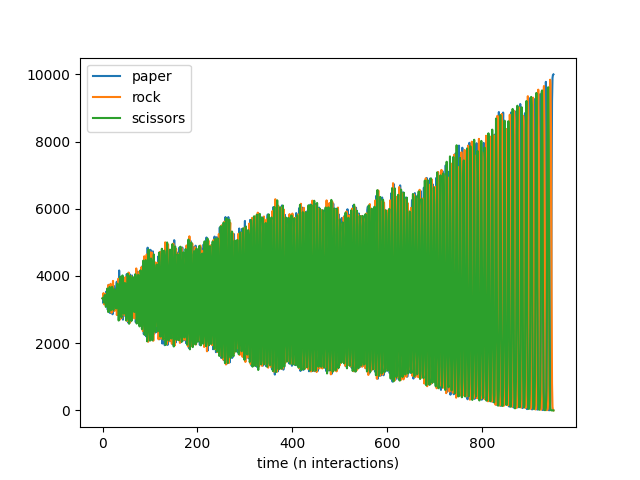

In [5]:
n = 10 ** 4
sim = Simulation(uniform_config(n), rps)
sim.run()
sim.history.plot()

Let's run some trials to get a sense of what this rate of growth might be.

  0%|          | 0/10 [00:00<?, ?it/s]

<Axes: xlabel='n', ylabel='time'>

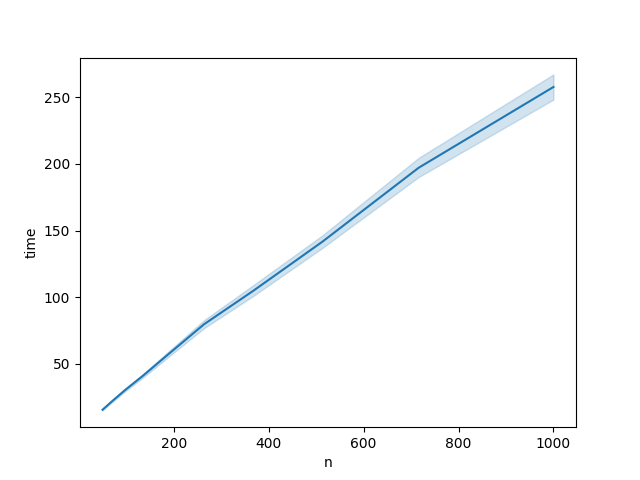

In [6]:
ns = [int(n) for n in np.geomspace(50, 10 ** 3, 10)]
df = time_trials(rps, ns, uniform_config, num_trials=1000, max_wallclock_time = 60)
fig, ax = plt.subplots()
sns.lineplot(x='n', y='time', data=df, ax = ax)

This suggests that the population becomes silent in linear time. This makes it pretty expensive to get larger population sizes, so we would need to increase `max_wallclock_time` and be more patient if we wanted to get good data that spans more orders of magnitude. We can take a look at the distributions of the times we sampled for each population size.

C:\Users\jpetr\AppData\Local\Temp\ipykernel_20732\3639181443.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x="n", y="time", data=df, palette="muted", scale="count")
C:\Users\jpetr\AppData\Local\Temp\ipykernel_20732\3639181443.py:2: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  ax = sns.violinplot(x="n", y="time", data=df, palette="muted", scale="count")


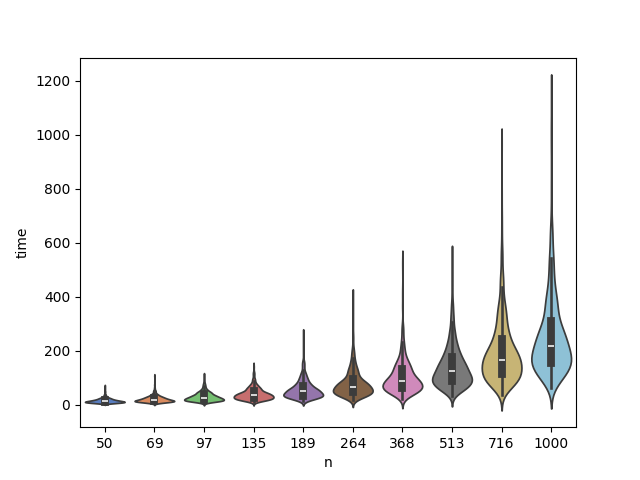

In [7]:
fig, ax = plt.subplots()
ax = sns.violinplot(x="n", y="time", data=df, palette="muted", scale="count")

# 7-state oscillator

A 7-state variant of the rock-paper-scissors oscillator was defined in the paper [Universal Protocols for Information Dissemination Using Emergent Signals](https://arxiv.org/abs/1705.09798):
The first state added is a control state `x`. One of the goals of their paper was the detection problem, where they will detect the presence of `x` because of the way the presence or absence of even a single copy affect the global dynamics.

`x` brings the other agent to a random state, which serves to bring the system toward the equilibrium of equal rock/paper/scissors and keeps any states from becoming extinct.

<Axes: xlabel='time (n interactions)'>

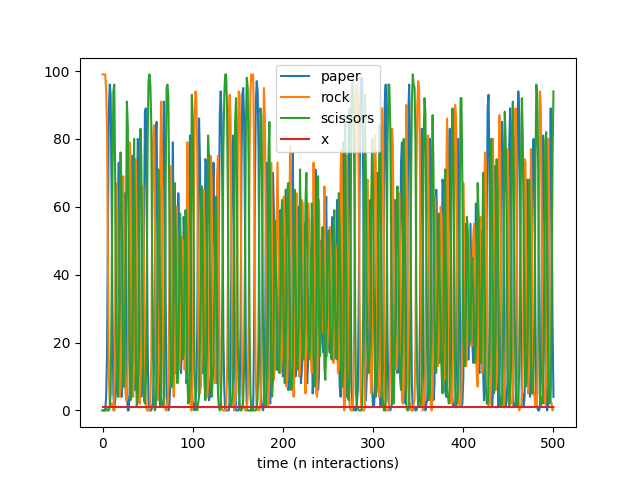

In [8]:
x = 'x'
rpsx = {
    (r,s): (r,r),
    (p,r): (p,p),
    (s,p): (s,s),
    (x,r): {(x,r):1/3, (x,p): 1/3, (x,s): 1/3},
    (x,p): {(x,r):1/3, (x,p): 1/3, (x,s): 1/3},
    (x,s): {(x,r):1/3, (x,p): 1/3, (x,s): 1/3},
}
n = 100
# Start with 1 copy of x in an otherwise silent configuration
init_config = {x: 1, r: n - 1}
sim = Simulation(init_config, rpsx)
sim.run(500)
sim.history.plot()

The absence of `x` will take a relatively long time to have an effect in large populations, because we saw that the time to become silent is scaling linearly with population size. To speed this up, the 7-state oscillator adds a 'lazy' and 'aggressive' variant of each state, whose dynamics serve to more quickly reach extinction in the absence of `x`.

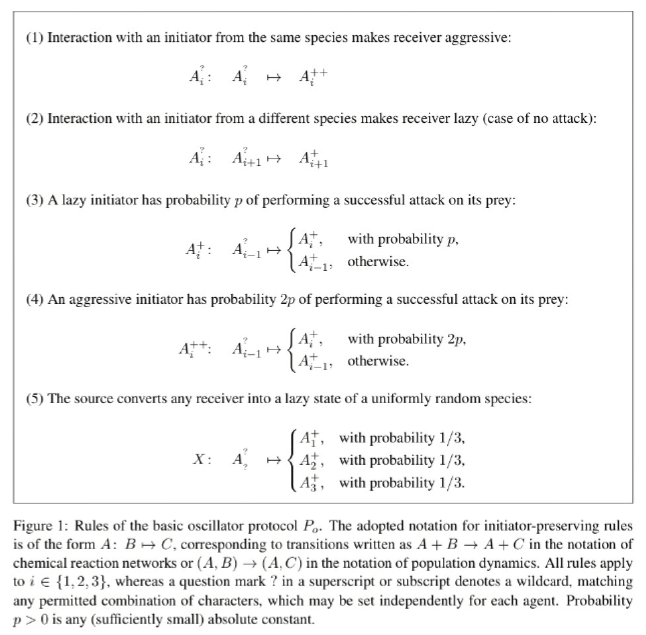

We can translate this pseudocode into a function that defines the rule:

In [9]:
# 7 states, the source, then 'rock', 'paper', 'scissors' in lazy '+' or aggressive '++' variants
states = ['x','0+','0++','1+','1++','2+','2++']

# The protocol is one-way, only
def seven_state_oscillator(a, b, p):
    if p > 0.5:
        return ValueError('p must be at most 0.5.')
    # (5) The source converts any receiver into a lazy state of a uniformly random species:
    if a == 'x' and b != 'x':
        return {(a, str(i) + '+'): 1/3 for i in range(3)}
    if b == 'x':
        return
    # (1) Interaction with an initiator from the same species makes receiver aggressive:
    if a[0] == b[0]:
        return a, b[0] + '++'
    # (2) Interaction with an initator from a different species makes receiver lazy (case of no attack):
    if int(b[0]) == (int(a[0]) + 1) % 3:
        return a, b[0] + '+'
    # (3) A lazy initiator has a probability p of performing a successful attack on its prey:
    if int(b[0]) == (int(a[0]) - 1) % 3 and len(a) == 2:
        return {(a, a[0] + '+'): p, (a, b[0] + '+'): 1-p}
    # (3) An aggressive initiator has a probability 2p of performing a successful attack on its prey:
    if int(b[0]) == (int(a[0]) - 1) % 3 and len(a) == 3:
        return {(a, a[0] + '+'): 2*p, (a, b[0] + '+'): 1-2*p}

In [10]:
n = 10 ** 3
# Start with 1 copy of x in an otherwise silent configuration
init_config = {x: 1, '0+': n - 1}
sim = Simulation(init_config, seven_state_oscillator, p = 0.1)

We can confirm that we got the logic correct by looking at the reachable states and reactions:

In [11]:
print(sim.state_list)
print(sim.reactions)

['0+', '0++', '1+', '1++', '2+', '2++', 'x']
 0+,  0+  -->   0+, 0++
 0+, 0++  -->  0++, 0++
 0+,  1+  -->   1+,  1+      with probability 0.1
0++,  1+  -->   1+,  1+      with probability 0.1
0++,  1+  -->   0+,  1+      with probability 0.9
 1+,  1+  -->   1+, 1++
 0+, 1++  -->   1+, 1++      with probability 0.1
 0+, 1++  -->   0+,  1+      with probability 0.5
0++, 1++  -->   1+, 1++      with probability 0.1
0++, 1++  -->   0+, 1++      with probability 0.4
0++, 1++  -->  0++,  1+      with probability 0.5
 1+, 1++  -->  1++, 1++
 0+,  2+  -->   0+,  0+      with probability 0.1
 0+,  2+  -->   0+,  2+      with probability 0.9
0++,  2+  -->   0+,  2+      with probability 0.5
0++,  2+  -->   0+, 0++      with probability 0.1
 1+,  2+  -->   2+,  2+      with probability 0.1
1++,  2+  -->   2+,  2+      with probability 0.1
1++,  2+  -->   1+,  2+      with probability 0.9
 2+,  2+  -->   2+, 2++
 0+, 2++  -->   0+,  0+      with probability 0.1
 0+, 2++  -->   0+,  2+      with p

<Axes: xlabel='time (n interactions)'>

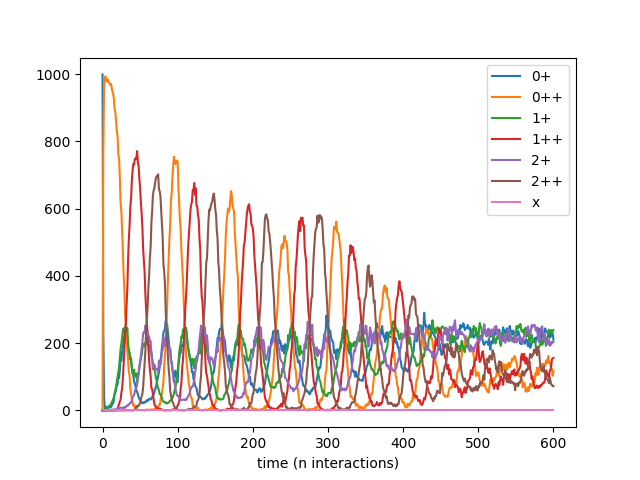

In [12]:
sim.run(100 * int(np.log(n)))
sim.history.plot()

Now we can try adding and removing `x` mid-simulation to verify that the starts and stops the oscillations.

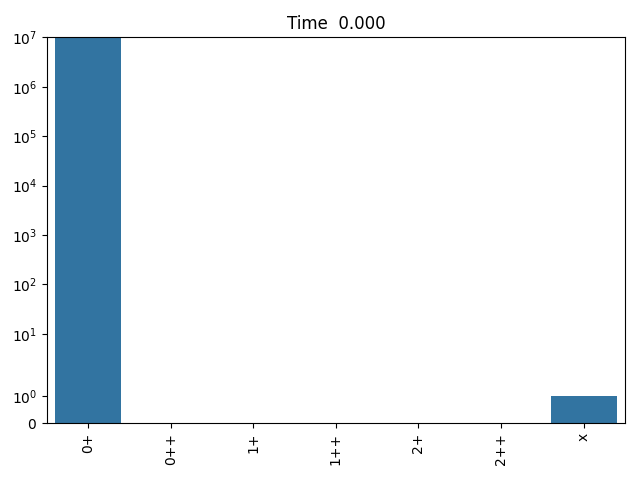

In [13]:
n = 10 ** 7
# Start with 1 copy of x in an otherwise silent configuration
init_config = {x: 1, '0+': n - 1}
sim = Simulation(init_config, seven_state_oscillator, p = 0.1)
sp = StatePlotter()
sim.add_snapshot(sp)
sp.ax.set_yscale('symlog')

If we want to watch the simulation in real time, we need to create this interactive figure before we tell it to run.

removing x
adding x


<Axes: xlabel='time (n interactions)'>

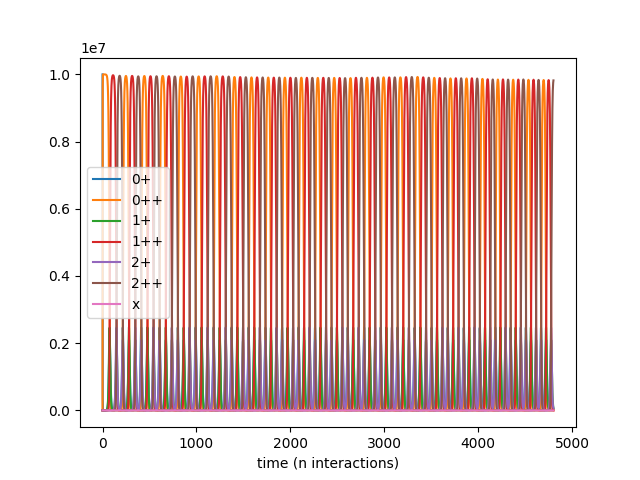

In [14]:
sim.run(100 * int(np.log(n)))
# Remove the one copy of x
print('removing x')
d = sim.config_dict
d[x] = 0
sim.set_config(d)
sim.run(100 * int(np.log(n)))
# Add back one copy of x
print('adding x')
d = sim.config_dict
d[x] = 1
sim.set_config(d)
sim.run(100 * int(np.log(n)))

sim.history.plot()

Notice the simulator was able to skip right through the middle period because once the clock shut down, there were no applicable transitions.

# Basis for a Phase Clock

This oscillator was used in the paper [Population Protocols are Fast](https://arxiv.org/abs/1802.06872) as the basis for a constant-state phase clock. For that, we need to create a small count of the signal `x`, and to be sure the clock keeps running, the count of `x` must stay positive. The simplest way to do this is simply to start with the entire population in state `x` and now allow multiple `x` to eliminate each other. This only requires changing one line of our protocol:

In [15]:
def seven_state_oscillator_leader_election(a, b, p):
    if p > 0.5:
        return ValueError('p must be at most 0.5.')
    # (5) The source converts any receiver into a lazy state of a uniformly random species:
    # Now this also applies to input pair (x, x), so the state x is doing simple leader election to eventually get down to one state
    if a == 'x':
        return {(a, str(i) + '+'): 1/3 for i in range(3)}
    if b == 'x':
        return
    # (1) Interaction with an initiator from the same species makes receiver aggressive:
    if a[0] == b[0]:
        return a, b[0] + '++'
    # (2) Interaction with an initator from a different species makes receiver lazy (case of no attack):
    if int(b[0]) == (int(a[0]) + 1) % 3:
        return a, b[0] + '+'
    # (3) A lazy initiator has a probability p of performing a successful attack on its prey:
    if int(b[0]) == (int(a[0]) - 1) % 3 and len(a) == 2:
        return {(a, a[0] + '+'): p, (a, b[0] + '+'): 1-p}
    # (3) An aggressive initiator has a probability 2p of performing a successful attack on its prey:
    if int(b[0]) == (int(a[0]) - 1) % 3 and len(a) == 3:
        return {(a, a[0] + '+'): 2*p, (a, b[0] + '+'): 1-2*p}

Once the count of `x` gets down to $O(n^{1-\epsilon})$, then we should start seeing oscillations start, which have a period of $O(\log n)$.

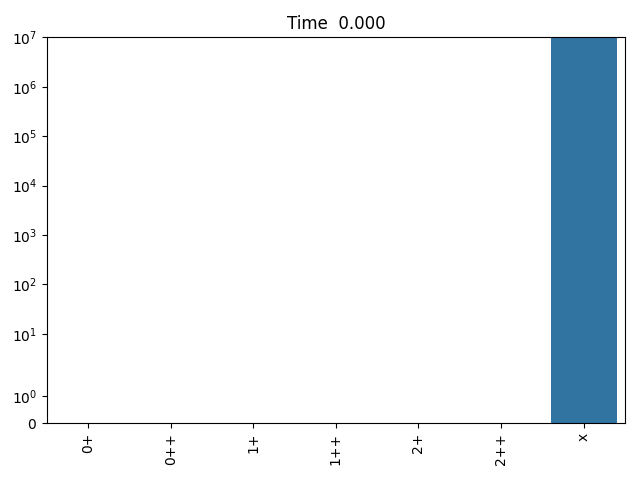

In [16]:
n = 10 ** 7
init_config = {x: n}
sim = Simulation(init_config, seven_state_oscillator_leader_election, p = 0.1)
sp = StatePlotter()
sim.add_snapshot(sp)
sp.ax.set_yscale('symlog')

<Axes: xlabel='time (n interactions)'>

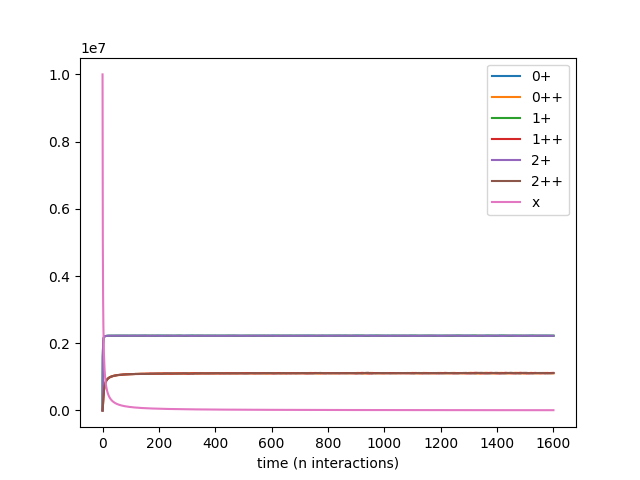

In [17]:
sim.run(100 * int(np.log(n)))
sim.history.plot()